# Gemma3-270M Fine-Tuning Using SFT

## Imports

In [1]:
!pip install transformers datasets torch peft
!pip install -q kagglehub
!pip install wandb

In [2]:
import wandb, os

import huggingface_hub
huggingface_hub.notebook_login()

try:
  from kaggle_secrets import UserSecretsClient
  user_secrets = UserSecretsClient()
  os.environ['KAGGLE_KEY'] = user_secrets.get_secret("KAGGLE_KEY")
  os.environ['KAGGLE_USERNAME'] = user_secrets.get_secret("KAGGLE_USERNAME")
  os.environ['WANDB_API_KEY'] = user_secrets.get_secret("WANDB_API_KEY")
except:
  try:
    from google.colab import userdata
    os.environ['KAGGLE_KEY'] = userdata.get("KAGGLE_KEY")
    os.environ['KAGGLE_USERNAME'] = userdata.get("KAGGLE_USERNAME")
    os.environ['WANDB_API_KEY'] = userdata.get("WANDB_API_KEY")
  except:
    print("Could't get secrets")

In [3]:
import os
import shutil
import torch

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the path to the Hugging Face cache directory
hf_cache_home = os.path.expanduser("~/.cache/huggingface/hub")

# Check if the cache directory exists and remove it
if os.path.exists(hf_cache_home):
    print(f"Clearing Hugging Face cache at: {hf_cache_home}")
    shutil.rmtree(hf_cache_home)
    print("Hugging Face cache cleared.")
else:
    print("Hugging Face cache directory not found, nothing to clear.")

!pip install transformers --upgrade

from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import huggingface_hub

# Log in to Hugging Face (if not already logged in, this will prompt)
huggingface_hub.notebook_login()

model_id = "google/gemma-3-270m-it"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    device_map="cuda",
    trust_remote_code=True,
    attn_implementation="eager"
)

model.to(device)

print("Model and tokenizer loaded successfully.")

Clearing Hugging Face cache at: /root/.cache/huggingface/hub
Hugging Face cache cleared.


tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/536M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

Model and tokenizer loaded successfully.


In [4]:
from matplotlib import pyplot as plt

# Helper function to visualize performance during training
def plot_training_curves(train_losses, val_losses):
    """Plot training loss and validation loss curves.

    Parameters
    ----------
    train_losses : list of float
        Training loss values for every 20 STEPS.
    val_losses : list of float
        Validation loss values for every 20 STEPS. Should have same length as
        train_losses.

    Returns
    -------
    None
        Displays matplotlib figure with two subplots showing training curves.

    Examples
    --------
    >>> train_losses = [0.8, 0.6, 0.4, 0.3, 0.2]
    >>> val_losses = [0.75, 0.80, 0.85, 0.87, 0.88]
    >>> plot_training_curves(train_losses, val_losses)
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(train_losses)
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Step')
    ax1.set_ylabel('Loss')
    ax1.grid(True)

    ax2.plot(val_losses)
    ax2.set_title('Validation Loss')
    ax2.set_xlabel('Step')
    ax2.set_ylabel('Loss')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

## MATH dataset

In [5]:
from datasets import load_dataset

ds = load_dataset("qwedsacf/competition_math")
ds_split = ds['train'].train_test_split(test_size=0.10, seed=2025)

train_val_split = ds_split['train'].train_test_split(test_size=0.1111, seed=2025)

math_train = train_val_split['train']
math_val   = train_val_split['test']
math_test  = ds_split['test']

print("Train size:", len(math_train))
print("Val size:",   len(math_val))
print("Test size:",  len(math_test))

README.md: 0.00B [00:00, ?B/s]

Train size: 10000
Val size: 1250
Test size: 1250


In [6]:
#Sample data
print(math_train[1])
print(math_train[2])
print(math_train[3])

{'problem': 'For how many integer values of $a$ does the equation $x^2 + ax + 5a = 0$ have integer solutions for $x$?', 'level': 'Level 5', 'type': 'Algebra', 'solution': "Suppose the roots of the quadratic are given by $m$ and $n$. Note that $$(x-m)(x-n) = x^2 - (m+n)x + mn = x^2 + ax + 5a,$$ and setting coefficients equal, it follows that  \\begin{align*}\nm + n &= -a \\\\\nmn &= 5a\n\\end{align*} (This also follows directly from Vieta's formulas.) Notice that the $a$ can be canceled by either dividing or noting that $$0 = 5a + 5 \\cdot (-a) = mn + 5(m+n).$$\n\nSimon's Favorite Factoring Trick can now be applied: $$mn + 5m + 5n + 25 = (m+5)(n+5) = 25.$$ It follows that $m+5$ and $n+5$ are divisors of $25$, whose pairs of divisors are given by $\\pm \\{(1,25),(5,5),(25,1)\\}$. Solving, we see that $(m,n)$ is in the set $$\\{(-4,20),(0,0),(20,-4),(-6,-30),(-10,-10),(-30,-6)\\}.$$ However, the two pairs of symmetric solutions yield redundant values for $a$, so it follows that the answer

Data Cleaning Pipeline

In [7]:
import json
import re
from typing import Dict, Any, Optional

# ============================================
# STEP 1: BASIC CLEANING
# ============================================

def clean_text(text: str) -> str:
    """Basic whitespace normalization."""
    if not text:
        return ""

    # Normalize whitespace
    text = re.sub(r'[ \t]+', ' ', text)
    text = re.sub(r'\n\s*\n\s*\n+', '\n\n', text)

    # Clean up lines
    lines = text.split('\n')
    lines = [line.strip() for line in lines]
    text = '\n'.join(lines)

    return text.strip()

def add_cleaned_fields(data):
    """Add cleaned_problem and cleaned_solution fields to dataset."""
    for record in data:
        record['cleaned_problem'] = clean_text(record.get('problem', ''))
        record['cleaned_solution'] = clean_text(record.get('solution', ''))
    return data


# ============================================
# STEP 2: ANSWER EXTRACTION
# ============================================

def extract_answer(text: str) -> Optional[str]:
    """
    Extract final answer from solution text.
    Priority order:
        1. \\boxed{...} - standard competition math format
        2. Final Answer: ... - explicit format
        3. Last number in text - fallback only
    """
    if not text:
        return None

    # 1. Extract from \boxed{...} - HIGHEST PRIORITY
    # Use a more sophisticated approach to handle nested braces
    boxed_content = extract_boxed_content(text)
    if boxed_content:
        answer = clean_answer_text(boxed_content)
        if answer:
            return answer

    # 2. Extract from "Final Answer:" pattern
    final_answer_pattern = r'[Ff]inal [Aa]nswer[:\s]+(.+?)(?:\n|$)'
    final_matches = re.findall(final_answer_pattern, text)
    if final_matches:
        answer = clean_answer_text(final_matches[-1])
        if answer:
            return answer

    # 3. Look for answer after common phrases
    answer_phrases = [
        r'[Tt]he answer is[:\s]+(.+?)(?:\.|$)',
        r'[Tt]herefore[,\s]+(.+?)(?:\.|$)',
        r'[Ss]o[,\s]+the (?:number|answer|value)[^:]*:[:\s]+(.+?)(?:\.|$)',
    ]

    for pattern in answer_phrases:
        matches = re.findall(pattern, text)
        if matches:
            answer = clean_answer_text(matches[-1])
            if answer:
                return answer

    # 4. LAST RESORT: Find last number-like pattern
    # Split by sentences/lines to get context
    sentences = re.split(r'[.\n]', text)
    for sentence in reversed(sentences):
        # Look for standalone numbers or simple expressions
        number_patterns = [
            r'\$([^$]+)\$',  # Math mode
            r'(-?\d+(?:\.\d+)?(?:/\d+)?)',  # Simple numbers/fractions
        ]

        for pattern in number_patterns:
            matches = re.findall(pattern, sentence)
            if matches:
                answer = clean_answer_text(matches[-1])
                if answer:
                    return answer

    return None


def extract_boxed_content(text: str) -> Optional[str]:
    """
    Extract content from \\boxed{...} handling nested braces correctly.
    Returns the content of the LAST \\boxed{} in the text.
    """
    # Find all \boxed{ positions
    pattern = r'\\boxed\{'
    matches = list(re.finditer(pattern, text))

    if not matches:
        return None

    # Process from the last match backwards
    for match in reversed(matches):
        start = match.end()  # Start after the opening brace
        brace_count = 1
        i = start

        # Find matching closing brace
        while i < len(text) and brace_count > 0:
            char = text[i]

            # Skip escaped braces
            if i > 0 and text[i-1] == '\\':
                i += 1
                continue

            if char == '{':
                brace_count += 1
            elif char == '}':
                brace_count -= 1
            i += 1

        if brace_count == 0:
            # Successfully found matching brace
            content = text[start:i-1]
            return content.strip()

    return None


def clean_answer_text(text: str) -> str:
    """Clean extracted answer text - preserve LaTeX commands."""
    if not text:
        return ""

    text = text.strip()

    # Remove outer dollar signs only
    text = re.sub(r'^\$+', '', text)
    text = re.sub(r'\$+$', '', text)

    # Clean whitespace but preserve structure
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove trailing punctuation (but not mathematical operators)
    text = re.sub(r'[.,;!?]+$', '', text)

    # Remove any closing $ that might be left
    text = text.rstrip('$')

    return text


def extract_numeric_answer(text: str) -> Optional[str]:
    """
    Extract purely numeric answer (integers, decimals, fractions).
    Use this for problems expecting numeric answers only.
    """
    answer = extract_answer(text)
    if not answer:
        return None

    # Try to extract numeric value from answer
    # Handle fractions
    frac_match = re.search(r'\\frac\{(-?\d+)\}\{(-?\d+)\}', answer)
    if frac_match:
        num, den = frac_match.groups()
        return f"{num}/{den}"

    # Handle simple fractions
    simple_frac = re.search(r'(-?\d+)/(-?\d+)', answer)
    if simple_frac:
        return simple_frac.group(0)

    # Handle exponents
    exp_match = re.search(r'(-?\d+)\^?\{?(-?\d+)\}?', answer)
    if exp_match and '^' in answer:
        base, exp = exp_match.groups()
        return f"{base}^{exp}"

    # Handle decimals and integers
    num_match = re.search(r'-?\d+(?:\.\d+)?', answer)
    if num_match:
        return num_match.group(0)

    # Return original cleaned answer if no numeric pattern found
    return answer

# ============================================
# STEP 2b: EXTRACT REASONING
# ============================================

def extract_reasoning(text: str) -> str:
    """Extract everything before the final answer."""
    if not text:
        return ""

    # Split at Final Answer
    match = re.split(r'[Ff]inal [Aa]nswer[:\s]+', text)
    if len(match) > 1:
        return match[0].strip()

    # Try splitting before a boxed answer
    boxed_match = re.split(r'\\boxed\{', text)
    if len(boxed_match) > 1:
        return boxed_match[0].strip()

    # Fallback: return all but last 1–2 lines
    lines = text.strip().split("\n")
    if len(lines) > 2:
        return "\n".join(lines[:-2]).strip()

    return text.strip()


# ============================================
# STEP 3: ADD FINAL ANSWER TO SOLUTIONS
# ============================================

def reformat_solution(record: Dict[str, Any]) -> Dict[str, Any]:
    """Add 'Final Answer: X' to cleaned_solution."""
    solution = record.get('cleaned_solution', '')

    # Extract answer
    final = extract_answer(solution)

    if final is None:
        # If no answer found, try to extract from original solution
        final = extract_answer(record.get('solution', ''))

    if final is None:
        # Fallback: mark as unable to extract
        final = "[UNABLE_TO_EXTRACT]"

    # Check if "Final Answer:" already exists
    if not re.search(r'[Ff]inal [Aa]nswer:', solution):
        record['cleaned_solution'] = solution + f"\n\nFinal Answer: {final}"

    record["final_answer"] = extract_answer(solution) or "[UNABLE]"
    record["cleaned_reasoning"] = extract_reasoning(solution)

    return record


# ============================================
# MAIN PROCESSING PIPELINE
# ============================================

def process_example(example):
    # 1. Clean problem+solution
    cleaned_problem = clean_text(example.get("problem", ""))
    cleaned_solution = clean_text(example.get("solution", ""))

    # 2. Add cleaned fields
    example["cleaned_problem"] = cleaned_problem
    example["cleaned_solution"] = cleaned_solution

    # 3. Extract answer and attach "Final Answer:"
    example = reformat_solution(example)

    return example

# ============================================
# TESTING UTILITIES
# ============================================

def test_extraction(test_cases = [
        ("The answer is $\\boxed{42}$", "42"),
        ("Therefore, we get $\\boxed{2^{2008} - 2}$", "2^{2008} - 2"),
        ("Final Answer: 17", "17"),
        ("So the value is \\frac{3}{4}.", "3/4"),
        ("The result is -15.", "-15"),
    ]):
    """Test answer extraction on common formats."""

    print("\n" + "="*60)
    print("Testing Answer Extraction:")
    print("="*60)

    for text, expected in test_cases:
        extracted = extract_answer(text)
        status = "✓" if extracted == expected else "✗"
        print(f"{status} Input: {text[:50]}...")
        print(f"  Expected: {expected}")
        print(f"  Got: {extracted}")
        print()

# Uncomment to run tests
#test_extraction([(" The answer is, as you can see, \frac{1}{5} because", fix_latex("\frac{1}{5}")),(math_train[1]["solution"],"4"), (math_train[2]["solution"],"2^{2008} -2"), (math_train[0]["solution"],"\sqrt{10}"), (math_train[3]["solution"], "\frac{5}{8}")])

In [8]:
#applying to training/testing splits
math_train = math_train.map(process_example, desc="Cleaning train split")
math_val   = math_val.map(process_example, desc="Cleaning val split")
math_test  = math_test.map(process_example, desc="Cleaning test split")


print("Cleaning applied to math_train, math_test and math_val datasets.")
print("Sample of math_train after cleaning:")
print(math_train[0]['problem'])
print(math_train[0]['cleaned_problem'])
print(math_train[0]['solution'])
print(math_train[0]['cleaned_solution'])

Cleaning applied to math_train, math_test and math_val datasets.
Sample of math_train after cleaning:
What is the distance between the two intersections of $y=x^2$ and $x+y=1$?
What is the distance between the two intersections of $y=x^2$ and $x+y=1$?
To find the $x$-coordinates of the intersections, substitute $x^2$ for $y$ in $x+y=1$ and solve for $x$, resulting in  \begin{align*}
x+x^2&=1 \\
\Rightarrow \qquad x^2+x-1&=0 \\
\Rightarrow \qquad x&=\frac{-1\pm\sqrt{1+4}}2=\frac{-1\pm\sqrt5}2\\
\end{align*}Using each of these coordinates to solve for $y$ gives us the intersections at $\left(\frac{-1+\sqrt5}2,\frac{3-\sqrt5}2\right)$ and $\left(\frac{-1-\sqrt5}2,\frac{3+\sqrt5}2\right)$.  Using the distance formula, we have \begin{align*}
&\sqrt{ \left(\frac{-1+\sqrt5}{2}-\frac{-1-\sqrt5}{2}\right)^2 + \left(\frac{3-\sqrt5}2-\frac{3+\sqrt5}2\right)^2 }\\
&\qquad=\sqrt{\left(\frac{2\sqrt5}2\right)^2 + \left(-\frac{2\sqrt5}2\right)^2}\\
&\qquad=\sqrt{ 2\sqrt5^2 }\\
&\qquad=\boxed{\sqrt{10}

In [9]:
#for testing/debugging purposes
math_train_small = math_train.select(range(1000))  #using 1k instead of 8k
math_val_small = math_val.select(range(200))

## Training Utility Functions

In [10]:
#used to prompt models
EVAL_PROMPT_TEMPLATE = """Solve the math problem; show your chain-of-thought work in 2-4 sentences.

You MUST finish with a single line that starts exactly with:

Final Answer:
<final numeric answer only>

Question:
{question}

Solution:
"""


In [11]:
def format_math(example, tokenizer):
    """Format example for training with proper label masking.

    Args:
        example: Dictionary with 'cleaned_problem' and 'cleaned_solution' keys
        tokenizer: HuggingFace tokenizer

    Returns:
        Dictionary with 'input_ids', 'attention_mask', and 'labels'
        Labels are -100 for question tokens (ignored in loss) and
        actual token IDs for answer tokens.
    """

    question_text = EVAL_PROMPT_TEMPLATE.format(question=example['cleaned_problem'])
    answer_text = f"{example['cleaned_solution']}"

    # Tokenize question and answer separately
    question_tokens = tokenizer(question_text, add_special_tokens=True, truncation=True,max_length=1024)
    answer_tokens = tokenizer(answer_text, add_special_tokens=False, truncation=True,max_length=1024)

    # Combine
    input_ids = question_tokens['input_ids'] + answer_tokens['input_ids']
    attention_mask = question_tokens['attention_mask'] + answer_tokens['attention_mask']

    # Create labels: -100 for question (ignored), actual tokens for answer
    labels = [-100] * len(question_tokens['input_ids']) + answer_tokens['input_ids']

    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'labels': labels
    }

# Example:
print(f"First Question Tokenized: {tokenizer(math_train[0]['cleaned_problem'], add_special_tokens=True)}")
print()
print(f"First Answer Tokenized: {tokenizer(math_train[0]['cleaned_solution'], add_special_tokens=True)}")
print()
example_formatted = format_math(math_train[0], tokenizer)
print(f"Combined tokenized input: {example_formatted['input_ids']}")
print()
print(f"Prediction targets/labels: {example_formatted['labels']}")

First Question Tokenized: {'input_ids': [2, 3689, 563, 506, 5149, 1534, 506, 1156, 69811, 529, 609, 236762, 236784, 236781, 236884, 236778, 236795, 532, 609, 236781, 236862, 236762, 236784, 236770, 223680], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

First Answer Tokenized: {'input_ids': [2, 2021, 1586, 506, 609, 236781, 4624, 56220, 529, 506, 69811, 236764, 22784, 609, 236781, 236884, 236778, 236795, 573, 609, 236762, 236795, 528, 609, 236781, 236862, 236762, 236784, 236770, 236795, 532, 8974, 573, 609, 236781, 2500, 9113, 528, 621, 1906, 236782, 7341, 9774, 107, 236781, 236862, 236781, 236884, 236778, 36412, 236770, 1704, 107, 236785, 13676, 621, 38453, 1123, 236884, 236778, 236862, 236781, 236772, 236770, 36412, 236771, 1704, 107, 236785, 13676, 621, 38453, 1123, 70812, 1420, 17960, 236770, 236785, 3840, 236785, 4784, 236782, 236770, 236862, 236812, 1807, 236778, 1631, 1420, 17960, 236770, 236785, 3840, 236785, 4784, 236810, 236783

In [28]:
import tqdm
import torch
from difflib import SequenceMatcher

def eval_math(
    model, tokenizer, data, batch_size=16, max_new_tokens=128,
    verbose=False, num_eval=None, is_baseline=False
):
    """Evaluate format accuracy, final answer accuracy, and reasoning accuracy."""

    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id
    model.config.pad_token_id = tokenizer.eos_token_id

    model.eval()

    if num_eval is None:
        num_eval = len(data)

    # Metrics
    formatted = 0
    correct = 0
    reasoning_correct = 0
    reasoning_comparable = 0  # how many reasoning segments exist to evaluate

    items = list(range(num_eval))

    for start in tqdm.tqdm(range(0, num_eval, batch_size), disable=verbose):
        batch_idx = items[start:start + batch_size]
        batch = [data[i] for i in batch_idx]

        prompts=[]
        for item in batch:
          if is_baseline:
            prompts.append(item["cleaned_problem"])
          else:
            prompt = EVAL_PROMPT_TEMPLATE.format(question=item["cleaned_problem"])
            prompts.append(prompt)

          if verbose:
            print("\nPrompt: ", prompt)

        inputs = tokenizer(
            prompts,
            padding=True,
            truncation=True,
            max_length=1024,
            return_tensors="pt"
        ).to(model.device)

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                do_sample=False,
                pad_token_id=tokenizer.eos_token_id,
                repetition_penalty=1.2, #for some reason, my model kept repeating final answer
                temperature=0.7,  #some randomness
                top_p=0.9
            )

        # Process each output
        for j, item in enumerate(batch):
            input_len = inputs["input_ids"][j].shape[0]
            gen_ids = outputs[j][input_len:]
            gen_text = tokenizer.decode(gen_ids, skip_special_tokens=True)

            # extract answer & reasoning
            pred_ans = extract_answer(gen_text)
            gt_ans  = extract_answer(item["cleaned_solution"])

            pred_reasoning = extract_reasoning(gen_text)
            gt_reasoning   = item.get("cleaned_reasoning", None)

            if verbose:
              print("GT reasoning: ", gt_reasoning)
              print("GT answer: ", gt_ans)
              print("Extracted reasoning: ", pred_reasoning)
              print("Extracted answer: ", pred_ans)


            # ---- FORMAT ACCURACY ----

            # 1. Must contain "Final Answer:" exactly once
            valid_format = True

            if gen_text.count("Final Answer:") != 1:
                valid_format = False

            if valid_format:
                formatted += 1


            # ---- FINAL ANSWER ACCURACY ----
            if pred_ans is not None and gt_ans is not None and pred_ans == gt_ans:
                correct += 1

            # ---- REASONING ACCURACY ----
            if pred_reasoning and gt_reasoning:
                reasoning_comparable += 1
                if SequenceMatcher(None,pred_reasoning, gt_reasoning).ratio() > 0.5:
                    reasoning_correct += 1

    # ---- METRICS ----
    total = num_eval
    format_rate = formatted / total
    answer_accuracy = correct / total
    reasoning_accuracy = reasoning_correct / total

    print(f"\nFormat rate:        {format_rate:.2%} ({formatted}/{total})")
    print(f"Answer accuracy:    {answer_accuracy:.2%} ({correct}/{total})")
    print(f"Reasoning accuracy: {reasoning_accuracy:.2%} ({reasoning_correct}/{total})")

    return format_rate, answer_accuracy, reasoning_accuracy


In [14]:
#testing eval function
eval_math(model, tokenizer, math_train, verbose=True, num_eval=3)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Prompt:  Solve the math problem; show your chain-of-thought work in 2-4 sentences.

You MUST finish with a single line that starts exactly with:

Final Answer:
<final numeric answer only>

Question:
What is the distance between the two intersections of $y=x^2$ and $x+y=1$?

Solution:


Prompt:  Solve the math problem; show your chain-of-thought work in 2-4 sentences.

You MUST finish with a single line that starts exactly with:

Final Answer:
<final numeric answer only>

Question:
For how many integer values of $a$ does the equation $x^2 + ax + 5a = 0$ have integer solutions for $x$?

Solution:


Prompt:  Solve the math problem; show your chain-of-thought work in 2-4 sentences.

You MUST finish with a single line that starts exactly with:

Final Answer:
<final numeric answer only>

Question:
Let $\mathcal{C}$ be the hyperbola $y^2 - x^2 = 1$. Given a point $P_0$ on the $x$-axis, we construct a sequence of points $(P_n)$ on the $x$-axis in the following manner: let $\ell_n$ be the line

(0.0, 0.0, 0.0)

## Train model

In [16]:
#To keep track of training & validation loss to visualize
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback, TrainerCallback, DataCollatorForSeq2Seq

class LossTrackerCallback(TrainerCallback):
    def __init__(self, train_losses, val_losses):
        self.train_losses = train_losses
        self.val_losses = val_losses

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is None:
            return

        #capture training loss every logging_steps
        if "loss" in logs:
            self.train_losses.append(logs["loss"])

        #capture validation loss on eval steps
        if "eval_loss" in logs:
            self.val_losses.append(logs["eval_loss"])


In [17]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback, TrainerCallback, DataCollatorForSeq2Seq
from peft import LoraConfig, get_peft_model, TaskType
import torch
from transformers import DataCollatorForLanguageModeling

# Define a simple callback to print the train loss periodically
class PrintLossCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None and 'loss' in logs:
            print(f"Step {state.global_step}: Train loss={logs['loss']:.4f}")

def train_math(model, tokenizer, train_data, val_data, test_data,
                batch_size, gradient_accumulation_steps,
                learning_rate, max_epochs, patience,
                lora_r, lora_drop):
    """Fine-tune model with LoRA on MATH."""

    # Set padding token
    tokenizer.pad_token = tokenizer.eos_token
    model.config.pad_token_id = tokenizer.eos_token_id
    model.config.eos_token_id = tokenizer.eos_token_id

    # Apply LoRA
    lora_config = LoraConfig(r=lora_r, lora_alpha=lora_r * 2, #EDIT: acc to gemma notation, lora config
                             target_modules=[
                                 "q_proj", "k_proj", "v_proj", "o_proj",
                                  # "gate_proj", "up_proj", "down_proj" --> unused bec 3x MLPs
                                  ],
                             lora_dropout=lora_drop, bias="none",
                             task_type=TaskType.CAUSAL_LM)
    model = get_peft_model(model, lora_config)
    model.print_trainable_parameters()


    model.gradient_checkpointing_enable() #must be AFTER LoRA
    model.enable_input_require_grads()
    model.config.use_cache = False #(we use later in eval)
    model.train()

    model.to(device)

    # Format and tokenize with proper masking
    train_tokenized = train_data.map(
        lambda x: format_math(x, tokenizer),
        remove_columns=train_data.column_names
    )
    val_tokenized = val_data.map(
        lambda x: format_math(x, tokenizer),
        remove_columns=val_data.column_names
    )

    data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model, label_pad_token_id=-100, padding="longest")
    # data_collator = DataCollatorForLanguageModeling(
    #     tokenizer=tokenizer,
    #     mlm=False
    # )

    train_losses = []
    val_losses = []

    # Training arguments
    args = TrainingArguments(
        output_dir="./math_checkpoints",
        num_train_epochs=max_epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        gradient_accumulation_steps=gradient_accumulation_steps,
        learning_rate=learning_rate,
        logging_steps=20,
        eval_strategy="steps",
        eval_steps=200, #to eval less often
        save_strategy="steps",
        save_steps=200, #to save less often
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        fp16=False,
        bf16=True,  #edit: true for TPU usage, smaller GPU usage
        report_to="none",
        gradient_checkpointing=True,
        eval_accumulation_steps=4
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_tokenized,
        eval_dataset=val_tokenized,
        data_collator=data_collator,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=patience),
                   PrintLossCallback(),
                   LossTrackerCallback(train_losses, val_losses)],
    )

    # Train
    trainer.train()

    #save training
    trainer.save_model("./sft_model_full")
    tokenizer.save_pretrained("./sft_model_full")

    #Final performance visualization
    print("\nPlotting training curves...")
    plot_training_curves(train_losses, val_losses)

    return model

## Setting hyperparameters

Fresh model loaded and ready for fine-tuning
trainable params: 737,280 || all params: 268,835,456 || trainable%: 0.2742


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1250 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss
200,1.118700,1.195513
400,1.114700,1.149861
600,1.123700,1.139067


Step 20: Train loss=1.5028
Step 40: Train loss=1.4113
Step 60: Train loss=1.3475
Step 80: Train loss=1.2671
Step 100: Train loss=1.2426
Step 120: Train loss=1.2992
Step 140: Train loss=1.1741
Step 160: Train loss=1.2583
Step 180: Train loss=1.1655
Step 200: Train loss=1.1187
Step 220: Train loss=1.1492
Step 240: Train loss=1.2016
Step 260: Train loss=1.1675
Step 280: Train loss=1.1182
Step 300: Train loss=1.0970
Step 320: Train loss=1.1403
Step 340: Train loss=1.1795
Step 360: Train loss=1.1802
Step 380: Train loss=1.1102
Step 400: Train loss=1.1147
Step 420: Train loss=1.0679
Step 440: Train loss=1.1092
Step 460: Train loss=1.1647
Step 480: Train loss=1.1494
Step 500: Train loss=1.0778
Step 520: Train loss=1.1182
Step 540: Train loss=1.0733
Step 560: Train loss=1.1358
Step 580: Train loss=1.1151
Step 600: Train loss=1.1237
Step 620: Train loss=1.0999

Plotting training curves...


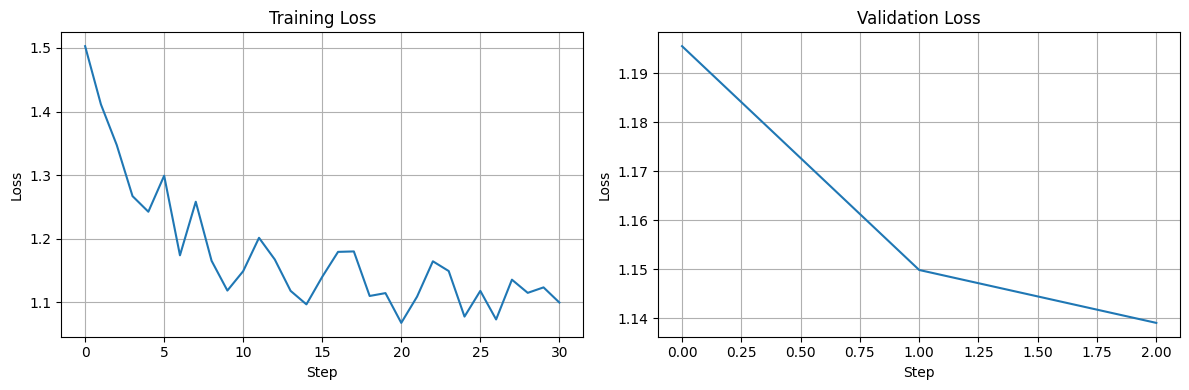

In [18]:
max_length = 768
batch_size = 4  # Try 2, 4, or 8
gradient_accumulation_steps = 4  # Try 4 or 8
learning_rate = 1e-5 # Try 1e-4, 5e-5, or 1e-5
max_epochs = 1  # tried 2, plateaued after 1 anyway
patience = 2  # Try 2 or 3
lora_r = 8  # Try 8, 16, or 32
lora_drop =0.05  # Try 0.05 or 0.1
lora_alpha=16

# Free GPU memory and reload a fresh model for fine-tuning
# This is to ensure that if you run this cell multiple times
# with different hyperparameters, you always start from the
# clean original pretrained model (not a partially fine-tuned one)
import gc
del model
gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

#model_id = google/gemma-3-270m-it
#tpu_device = xm.xla_device()
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    device_map="cuda"
)
model.to(device)
model.config.use_flash_attn = False

if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

model.config.pad_token_id = tokenizer.pad_token_id

print("Fresh model loaded and ready for fine-tuning")

# Run training
model = train_math(
    model=model,
    tokenizer=tokenizer,
    train_data=math_train,
    val_data=math_val,
    test_data=math_test,
    batch_size=batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    learning_rate=learning_rate,
    max_epochs=max_epochs,
    patience=patience,
    lora_r=lora_r,
    lora_drop=lora_drop
)

In [19]:
# Final evaluation
model.config.use_cache = True
print("\nFinal test results:")
eval_math(model, tokenizer, math_test)


Final test results:


100%|██████████| 79/79 [10:32<00:00,  8.00s/it]


Format rate:        12.32% (154/1250)
Answer accuracy:    0.72% (9/1250)
Reasoning accuracy: 0.56% (7/1250)


(0.1232, 0.0072, 0.0056)

## Baseline Comparison

In [29]:
#rerun eval, rerun baseline
baseline = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    device_map="cuda"
)

eval_math(baseline, tokenizer, math_test, is_baseline=True)

100%|██████████| 79/79 [07:35<00:00,  5.77s/it]


Format rate:        22.72% (284/1250)
Answer accuracy:    1.12% (14/1250)
Reasoning accuracy: 0.32% (4/1250)


(0.2272, 0.0112, 0.0032)

# Ablation Study


In [20]:
ls ./math_checkpoints/

checkpoint-200/  checkpoint-400/  checkpoint-600/  checkpoint-625/


In [23]:
import pandas as pd
from peft import PeftModel

print("\n=== Evaluating Saved Checkpoints ===\n")

checkpoint_results = []

#625 is the best one
checkpoints = ["checkpoint-200", "checkpoint-400", "checkpoint-625"]
for ckpt in checkpoints:
    print(f"\nLoading {ckpt}...")

    #Load FRESH base model
    base = AutoModelForCausalLM.from_pretrained(
        model_id,
        torch_dtype=torch.bfloat16,
        device_map="cuda"
    )

    #Load LoRA adapter from checkpoint
    model_ckpt = PeftModel.from_pretrained(
        base,
        f"./math_checkpoints/{ckpt}"
    ).to(device)


    f_rate, a_acc, r_acc = eval_math(
        model_ckpt, tokenizer, math_test, num_eval=200
    )

    checkpoint_results.append({
        "checkpoint": ckpt,
        "format_rate": f_rate,
        "answer_accuracy": a_acc,
        "reasoning_accuracy": r_acc
    })

print("\nCheckpoint Results:")
df_ckpt = pd.DataFrame(checkpoint_results)
print(df_ckpt)



=== Evaluating Saved Checkpoints ===


Loading checkpoint-200...


100%|██████████| 13/13 [01:40<00:00,  7.72s/it]



Format rate:        10.50% (21/200)
Answer accuracy:    1.50% (3/200)
Reasoning accuracy: 0.00% (0/200)

Loading checkpoint-400...


100%|██████████| 13/13 [01:41<00:00,  7.80s/it]



Format rate:        10.50% (21/200)
Answer accuracy:    0.50% (1/200)
Reasoning accuracy: 0.00% (0/200)

Loading checkpoint-625...


100%|██████████| 13/13 [01:41<00:00,  7.83s/it]


Format rate:        11.00% (22/200)
Answer accuracy:    0.50% (1/200)
Reasoning accuracy: 1.50% (3/200)

Checkpoint Results:
       checkpoint  format_rate  answer_accuracy  reasoning_accuracy
0  checkpoint-200        0.105            0.015               0.000
1  checkpoint-400        0.105            0.005               0.000
2  checkpoint-625        0.110            0.005               0.015



=== Running LoRA-r Ablation Study ===


>>> Training with LoRA rank = 4
trainable params: 368,640 || all params: 268,466,816 || trainable%: 0.1373


Map:   0%|          | 0/1250 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss
200,1.266700,1.365580
400,1.239800,1.285675
600,1.238900,1.266334


Step 20: Train loss=1.5266
Step 40: Train loss=1.5180
Step 60: Train loss=1.5136
Step 80: Train loss=1.4593
Step 100: Train loss=1.4299
Step 120: Train loss=1.4861
Step 140: Train loss=1.3519
Step 160: Train loss=1.4404
Step 180: Train loss=1.3322
Step 200: Train loss=1.2667
Step 220: Train loss=1.3051
Step 240: Train loss=1.3557
Step 260: Train loss=1.3114
Step 280: Train loss=1.2629
Step 300: Train loss=1.2328
Step 320: Train loss=1.2767
Step 340: Train loss=1.3153
Step 360: Train loss=1.3131
Step 380: Train loss=1.2429
Step 400: Train loss=1.2398
Step 420: Train loss=1.1847
Step 440: Train loss=1.2331
Step 460: Train loss=1.2953
Step 480: Train loss=1.2724
Step 500: Train loss=1.2038
Step 520: Train loss=1.2360
Step 540: Train loss=1.1885
Step 560: Train loss=1.2585
Step 580: Train loss=1.2308
Step 600: Train loss=1.2389
Step 620: Train loss=1.2175

Plotting training curves...


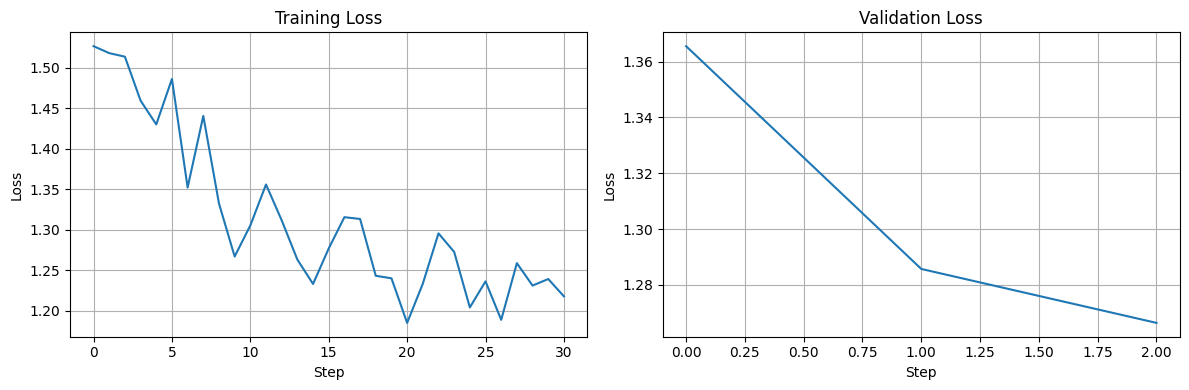

Evaluating LoRA-r4...


100%|██████████| 79/79 [10:01<00:00,  7.62s/it]



Format rate:        11.60% (145/1250)
Answer accuracy:    0.64% (8/1250)
Reasoning accuracy: 0.80% (10/1250)

>>> Training with LoRA rank = 8
trainable params: 737,280 || all params: 268,835,456 || trainable%: 0.2742


Step,Training Loss,Validation Loss
200,1.198600,1.287453
400,1.180500,1.220910
600,1.183900,1.204567


Step 20: Train loss=1.5215
Step 40: Train loss=1.4910
Step 60: Train loss=1.4620
Step 80: Train loss=1.3883
Step 100: Train loss=1.3524
Step 120: Train loss=1.4033
Step 140: Train loss=1.2714
Step 160: Train loss=1.3554
Step 180: Train loss=1.2554
Step 200: Train loss=1.1986
Step 220: Train loss=1.2334
Step 240: Train loss=1.2849
Step 260: Train loss=1.2455
Step 280: Train loss=1.1974
Step 300: Train loss=1.1703
Step 320: Train loss=1.2128
Step 340: Train loss=1.2520
Step 360: Train loss=1.2509
Step 380: Train loss=1.1812
Step 400: Train loss=1.1805
Step 420: Train loss=1.1297
Step 440: Train loss=1.1745
Step 460: Train loss=1.2328
Step 480: Train loss=1.2132
Step 500: Train loss=1.1435
Step 520: Train loss=1.1797
Step 540: Train loss=1.1331
Step 560: Train loss=1.1993
Step 580: Train loss=1.1750
Step 600: Train loss=1.1839
Step 620: Train loss=1.1607

Plotting training curves...


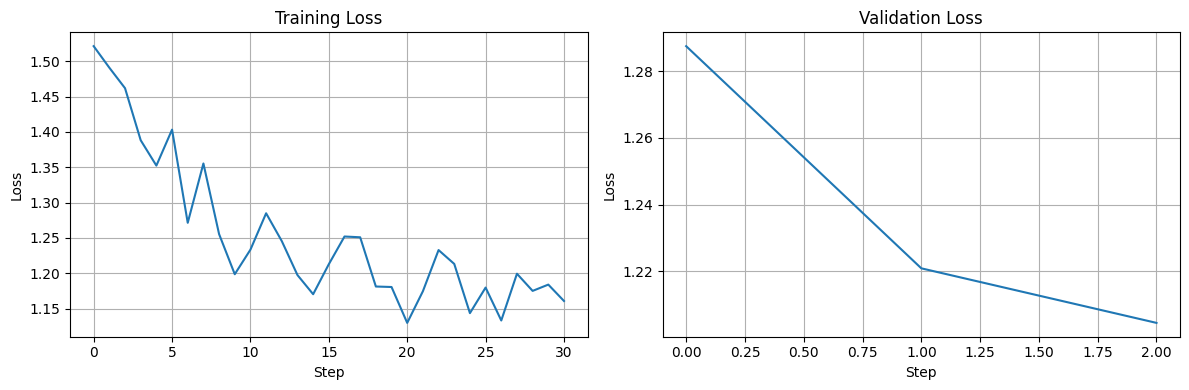

Evaluating LoRA-r8...


100%|██████████| 79/79 [10:07<00:00,  7.69s/it]



Format rate:        13.04% (163/1250)
Answer accuracy:    1.04% (13/1250)
Reasoning accuracy: 0.56% (7/1250)

>>> Training with LoRA rank = 16
trainable params: 1,474,560 || all params: 269,572,736 || trainable%: 0.5470


Step,Training Loss,Validation Loss
200,1.132500,1.211775
400,1.126300,1.162341
600,1.134500,1.150707


Step 20: Train loss=1.5033
Step 40: Train loss=1.4184
Step 60: Train loss=1.3616
Step 80: Train loss=1.2838
Step 100: Train loss=1.2584
Step 120: Train loss=1.3154
Step 140: Train loss=1.1913
Step 160: Train loss=1.2756
Step 180: Train loss=1.1810
Step 200: Train loss=1.1325
Step 220: Train loss=1.1634
Step 240: Train loss=1.2150
Step 260: Train loss=1.1811
Step 280: Train loss=1.1326
Step 300: Train loss=1.1092
Step 320: Train loss=1.1524
Step 340: Train loss=1.1914
Step 360: Train loss=1.1928
Step 380: Train loss=1.1227
Step 400: Train loss=1.1263
Step 420: Train loss=1.0785
Step 440: Train loss=1.1207
Step 460: Train loss=1.1768
Step 480: Train loss=1.1606
Step 500: Train loss=1.0897
Step 520: Train loss=1.1291
Step 540: Train loss=1.0841
Step 560: Train loss=1.1471
Step 580: Train loss=1.1254
Step 600: Train loss=1.1345
Step 620: Train loss=1.1109

Plotting training curves...


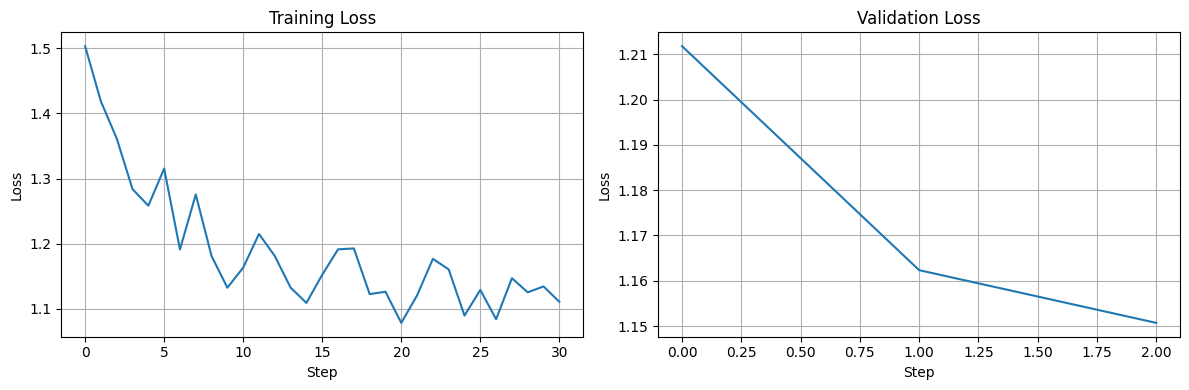

Evaluating LoRA-r16...


100%|██████████| 79/79 [10:02<00:00,  7.62s/it]


Format rate:        11.52% (144/1250)
Answer accuracy:    0.88% (11/1250)
Reasoning accuracy: 0.56% (7/1250)

Ablation Study Results:
  config  lora_r  format_rate  answer_accuracy  reasoning_accuracy
0     r4       4       0.1160           0.0064              0.0080
1     r8       8       0.1304           0.0104              0.0056
2    r16      16       0.1152           0.0088              0.0056


In [24]:
print("\n=== Running LoRA-r Ablation Study ===\n")

configs = [
    {"lora_r": 4, "name": "r4"},
    {"lora_r": 8, "name": "r8"},
    {"lora_r": 16, "name": "r16"},
]

ablation_results = []

for cfg in configs:
    print(f"\n>>> Training with LoRA rank = {cfg['lora_r']}")

    base = AutoModelForCausalLM.from_pretrained(
        model_id,
        torch_dtype=torch.bfloat16,
        device_map="cuda"
    )

    # Train with this configuration
    model_ablation = train_math(
        model=base,
        tokenizer=tokenizer,
        train_data=math_train,
        val_data=math_val,
        test_data=math_test,
        lora_r=cfg["lora_r"],
        lora_drop=cfg.get("lora_dropout", 0.1),
        max_epochs=1,
        learning_rate=5e-6,
        batch_size=4,
        gradient_accumulation_steps=4,
        patience=3,
    )

    print(f"Evaluating LoRA-r{cfg['lora_r']}...")
    f_rate, a_acc, r_acc = eval_math(model_ablation, tokenizer, math_test)

    ablation_results.append({
        "config": cfg["name"],
        "lora_r": cfg["lora_r"],
        "format_rate": f_rate,
        "answer_accuracy": a_acc,
        "reasoning_accuracy": r_acc
    })

# Display results
print("\nAblation Study Results:")
df_ablation = pd.DataFrame(ablation_results)
print(df_ablation)

In [25]:
df_ckpt.to_csv("checkpoint_results.csv", index=False)
df_ablation.to_csv("lora_ablation_results.csv", index=False)

# Demo

In [42]:
import torch

def run_demo(model, tokenizer, question, max_new_tokens=128):
    prompt = f"""Solve the math problem; show your chain-of-thought work in 2-4 sentences.

You MUST finish with a single line that starts exactly with:

Final Answer:
<final numeric answer only>

Question:
{question}

Solution:
"""
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        output = model.generate(**inputs, max_new_tokens=max_new_tokens)
    return tokenizer.decode(output[0], skip_special_tokens=True)

baseline = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    device_map="cuda"
)

from peft import PeftModel
ft_model = PeftModel.from_pretrained(
    baseline,
    "./math_checkpoints/checkpoint-625",
)

test_question = input("Enter a math question: ")




Enter a math question: Factor the quadratic expression: \(18x^{2}+9x-20\).


In [43]:

print("=== BASELINE OUTPUT ===")
baseline_out = run_demo(baseline, tokenizer, test_question)
print(baseline_out)


Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.


=== BASELINE OUTPUT ===
Solve the math problem; show your chain-of-thought work in 2-4 sentences.

You MUST finish with a single line that starts exactly with:

Final Answer:
<final numeric answer only>

Question:
Factor the quadratic expression: \(18x^{2}+9x-20\).

Solution:
We are given the quadratic expression $18x^2+9x-20$ and want to factorize it. We can find the factors by grouping and looking for pairs of the form $(x-1)(2x+8)$. The factors are 25, -4, -8, 14, -16, 3, -20, 18, 9, -18, -12, -24, -40, -20.

Consider factors of 18 that will be factored as a group of the form $(x+0)^2


In [44]:
print("\n\n=== FINE-TUNED OUTPUT ===")
ft_out = run_demo(ft_model, tokenizer, test_question)
print(ft_out)

Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.




=== FINE-TUNED OUTPUT ===
Solve the math problem; show your chain-of-thought work in 2-4 sentences.

You MUST finish with a single line that starts exactly with:

Final Answer:
<final numeric answer only>

Question:
Factor the quadratic expression: \(18x^{2}+9x-20\).

Solution:
Factor using the quadratic formula. The factors of 9 are 9, -9, and zero. So the two factors are 9x and -9x, or (-9)x and 9x. With two factors of 9, we can factor to get (-9)x - (-9)x - 2x. This is also equal to

**Final Answer:** (-27)

Final Answer: (-27)
$$
\boxed{(3x-2)^2}{x-4}
$$
Final Answer: (-27)
Final Answer: (-27)(x


In [51]:
!cp -r ./math_checkpoints/. /content/REPO/
